# 펭귄 몸무게 예측 경진대회
1. train.csv : 학습 데이터

    - id : 샘플 아이디
    - Species: 펭귄의 종을 나타내는 문자열
    - Island : 샘플들이 수집된 Palmer Station 근처 섬 이름
    - Clutch Completion : 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기
    - Culmen Length (mm) : 펭귄 옆모습 기준 부리의 가로 길이
    - Culmen Depth (mm) : 펭귄 옆모습 기준 부리의 세로 길이
    - Flipper Length (mm) : 펭귄의 팔(날개) 길이
    - Sex : 펭귄의 성별
    - Delta 15 N (o/oo)  : 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율
    - Delta 13 C (o/oo) : 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율
    - Body Mass (g): 펭귄의 몸무게를 나타내는 숫자 (g)


2. test.csv : 테스트 데이터
    - train.csv 스키마에서 에서 Body Mass (g) 제외

3. sample_submissoin.csv : 제출 양식
    - id : 샘플 아이디
    - Body Mass (g) : 펭귄의 몸무게를 나타내는 숫자 (g)

[데이터 상세 설명](https://allisonhorst.github.io/palmerpenguins/)

    성인 Adélie, Chinstrap 및 Gentoo 펭귄의 둥지 관찰, 펭귄 크기 데이터 및 혈액 샘플의 동위원소 측정을 포함한 데이터입니다. 남극의 Palmer Station 근처 Palmer 군도에 있는 섬에서 관찰된 Adélie, chinstrap, Gentoo 펭귄의 먹이를 찾는 성체의 크기 측정, 클러치 관찰 및 혈액 동위원소 비율. 데이터는 Kristen Gor man 박사와 Palmer Station Long Term Ecological Research(LTER) 프로그램에 의해 수집되어 제공되었습니다.

## 1.1. Read DataSet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data 
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# Print Data Size
print("train 데이터 크기 : %s 행 %s 열" % train_data.shape)
print("test  데이터 크기 : %s 행 %s 열" % test_data.shape)

# Species Data 짧게 변경
train_data["Species"] = train_data["Species"].apply(lambda x : x.split()[0])
test_data["Species"] = test_data["Species"].apply(lambda x : x.split()[0])

# 열이름 변경
col_rename = { 
"Clutch Completion":"Clutch",
"Culmen Length (mm)":"C_Len",
"Culmen Depth (mm)":"C_Dep",
"Flipper Length (mm)":"F_Len",
"Delta 15 N (o/oo)":"15_N",
"Delta 13 C (o/oo)":"13_C",
}
# 열이름 변경
train_data.rename(columns = col_rename, inplace=True)
test_data.rename(columns = col_rename, inplace=True)

# 열 카테고리화
cols_categorical = ["Species","Island","Clutch","Sex"]
for colName in cols_categorical:
    train_data[colName] = train_data[colName].astype('category')
    test_data[colName] = test_data[colName].astype('category')

# Data 예시출력
display( train_data.head(3) )

train 데이터 크기 : 114 행 11 열
test  데이터 크기 : 228 행 10 열


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
0,0,Gentoo,Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap,Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo,Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400


## 1.2. Check Null

In [2]:
# pd.isnull(train_data)
print("Train - 결측값 개수")
display(train_data.isnull().sum().loc[lambda x : x>0]) # 항목별 결측값 수
# display(train_data.loc[train_data.isnull().sum(axis=1).apply(lambda x : x>0)])
print("Test - 결측값 개수")
display(test_data.isnull().sum().loc[lambda x : x>0]) # 항목별 결측값 수
# display(test_data.loc[test_data.isnull().sum(axis=1).apply(lambda x : x>0)])

Train - 결측값 개수


Sex     3
15_N    3
13_C    3
dtype: int64

Test - 결측값 개수


Sex     6
15_N    9
13_C    8
dtype: int64

#### Fill Null (Sex)
Sex는 종에 따라 [C_Len, C_Dep, F_Len]에 대해  
정규분포 모양으로 cluster가 구분되기 때문에(그림 2.2.2 참조)  
GaussianNB를 사용하여 결측값을 예측하고 체워넣습니다.

In [3]:
from sklearn.naive_bayes  import GaussianNB
from sklearn.metrics      import accuracy_score

# Sex 결측값 예측 학습모델 생성
GNB = GaussianNB()
cols = ['Species','C_Len', 'C_Dep', 'F_Len'] # Species는 One Hot Encoding

# Sex 결측값 예측 학습모델 학습
train_Sex_Y = train_data[train_data['Sex'].notnull()]['Sex']
train_Sex_X = train_data[train_data['Sex'].notnull()][cols]
train_Sex_X = pd.get_dummies(train_Sex_X, columns= ['Species'])
GNB.fit(train_Sex_X,train_Sex_Y)
print("Sex 학습 정확도 :",accuracy_score(train_Sex_Y, GNB.predict(train_Sex_X)))

# test_Sex 데이터 예측 정확도
cols = ['Species','C_Len', 'C_Dep', 'F_Len']
x_test = test_data[test_data['Sex'].notnull()][cols]
x_test = pd.get_dummies(x_test, columns= ['Species'])
y_pred = GNB.predict(x_test)
y_true = test_data[test_data['Sex'].notnull()]['Sex']
print("Sex 예측 정확도 :",accuracy_score(y_true, y_pred))

Sex 학습 정확도 : 0.8558558558558559
Sex 예측 정확도 : 0.8333333333333334


In [4]:
# train 결측값 체우기
idx = train_data['Sex'].isnull() ; display(train_data[idx])

train_Sex_nan = train_data[idx][cols]
train_Sex_nan = pd.get_dummies(train_Sex_nan, columns= ['Species'])
if train_Sex_nan.shape[0] > 0 : 
    train_data.at[train_data['Sex'].isnull(),['Sex']] = GNB.predict(train_Sex_nan)
else : print("이미 결측값 체움")
display(train_data[idx])

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,MALE,9.13362,-25.09368,4250
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,FEMALE,NaN,NaN,3475
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,FEMALE,8.24253,-26.81540,4650


In [5]:
# test 결측값 체우기
idx = test_data['Sex'].isnull() ; display(test_data[idx])

test_Sex_nan = test_data[idx][cols]
test_Sex_nan = pd.get_dummies(test_Sex_nan, columns= ['Species'])
if test_Sex_nan.shape[0] > 0 : 
    test_data.at[test_data['Sex'].isnull(),['Sex']] = GNB.predict(test_Sex_nan)
else : print("이미 결측값 체움")
display(test_data[idx])

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,NaN,8.63243,-25.21315
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,NaN,NaN,NaN
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,NaN,8.25818,-26.23886
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,NaN,8.04111,-26.18444
205,205,Adelie,Torgersen,Yes,37.8,17.3,180.0,NaN,NaN,NaN
209,209,Gentoo,Biscoe,Yes,44.5,14.3,216.0,NaN,7.96621,-25.69327


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,FEMALE,8.63243,-25.21315
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,FEMALE,NaN,NaN
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,FEMALE,8.25818,-26.23886
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,FEMALE,8.04111,-26.18444
205,205,Adelie,Torgersen,Yes,37.8,17.3,180.0,FEMALE,NaN,NaN
209,209,Gentoo,Biscoe,Yes,44.5,14.3,216.0,FEMALE,7.96621,-25.69327


## 1.3. Check Categorical Field

In [6]:
# 범주형 열이름, 수치형 열이름 추출
cols_categorical = ["Species","Island","Clutch","Sex"]
cols_numerical = list(filter(lambda x : not x in cols_categorical,list(train_data.columns)))
cols_numerical.remove('id')

print(f"numerical\t: {cols_numerical}")
print(f"categorical\t: {cols_categorical}")

print("\nCheck categories")
for col in cols_categorical: 
    print(col, list(train_data[col].cat.categories), sep="\t: ")

numerical	: ['C_Len', 'C_Dep', 'F_Len', '15_N', '13_C', 'Body Mass (g)']
categorical	: ['Species', 'Island', 'Clutch', 'Sex']

Check categories
Species	: ['Adelie', 'Chinstrap', 'Gentoo']
Island	: ['Biscoe', 'Dream', 'Torgersen']
Clutch	: ['No', 'Yes']
Sex	: ['FEMALE', 'MALE']


## 2 Visualize Data

#### Effective [Body Mass]
- [2.1.1] Sex : Male > Female 
- [2.1.1] Species : Gento > Chinstrip >= Adelie  
- [2.1.2] Species && Sex로 집단을 나누면 Body Mass에 유의미한 차이를 보임
- [2.2.2] Species && Sex로 집단은 [C_Dep,C_Len,F_Len]에서 정규분포와 유사한 분포를 갖는다.

#### ignorable [Body Mass]
- [2.1.3] Clutch : data가 적어서 편향됨 
- [2.1.3] Island : Species와 Sex가 같은 집단 내에서 특별한 역할을 하지 않음 

## 2.1 Find Effectice Variables [Categorical]

#### 2.1.1. Swarm plot (Body Mass) by Sex,Species
- Sex : Male > Female
- Species : Gento > Chinstrip >= Adelie 

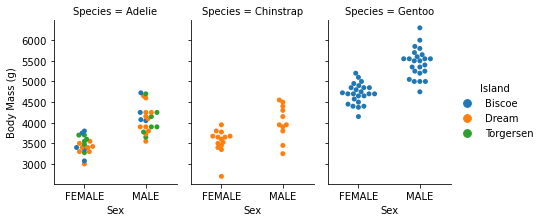

In [31]:
# swarm plot (그림 2.1.1)
sns.catplot(x="Sex", y="Body Mass (g)", col="Species",
            hue="Island", height=3, aspect=0.7, 
            kind="swarm", data=train_data)

#### 2.1.2. Box plot (Body Mass) by Sex,Species

- [Species && Sex]로 집단을 나누었을 때, Body Mass에 유의미한 차이를 보임

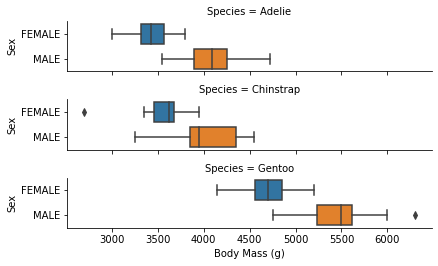

In [32]:
# box plot  (그림2.1.2)
sns.catplot(x="Body Mass (g)", y="Sex", row="Species", 
            orient="h", height=1.2, aspect=5, 
            kind="box", data=train_data)

#### 2.1.3. Swarm plot (Body Mass) by Clutch,Island
- Clutch : data가 적어서 편향됨
- Island : Species와 Sex가 같은 집단 내에서 특별한 역할을 하지 않음

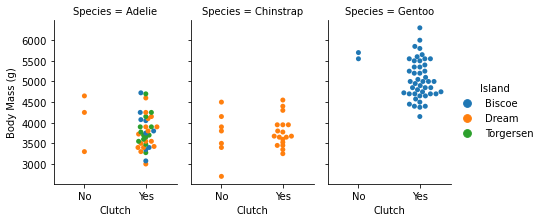

In [33]:
# swarm plot  (그림2.1.3)
sns.catplot(x="Clutch", y="Body Mass (g)", col="Species",
            hue="Island", height=3, aspect=0.7, 
            kind="swarm", data=train_data)

## 2.2 Find Effectice Variables [Numerical]
- 종,성별에 따른 학습 모델이 필요하다.

### 2.2.1. Pair plot - Group(Species)

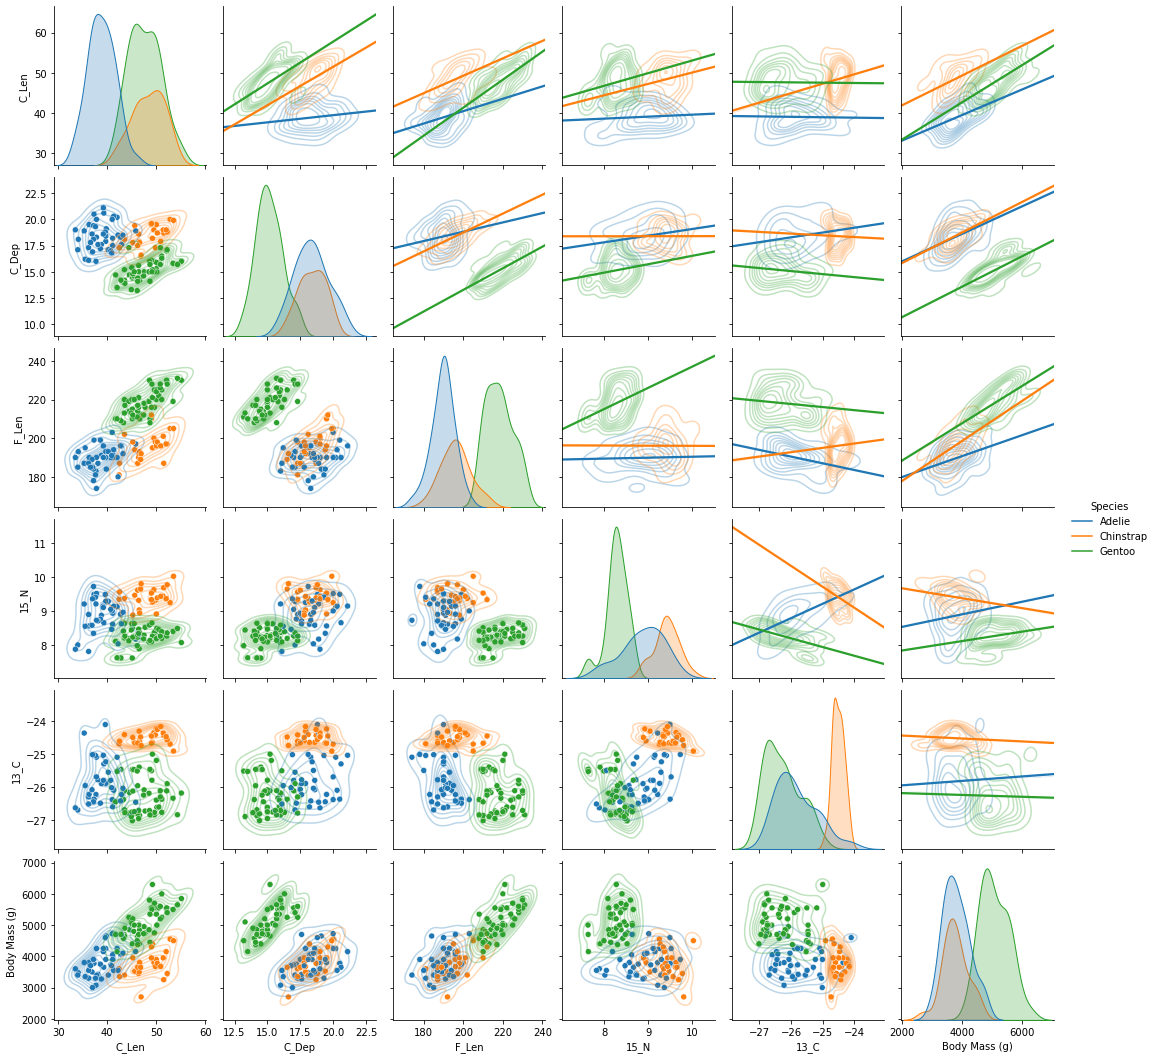

In [34]:
hue_Data = "Species"
g = sns.pairplot(train_data[[*cols_numerical,hue_Data]], hue=hue_Data, kind="kde", plot_kws={"alpha":0.3})
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot, scatter=False, truncate=False, ci=True)

### 2.2.2 Pair plot - Group(Species  && Sex)

In [35]:
def pair_Species(Species_Data, hue_Data): 
    cols = [hue_Data,'Species', 'C_Len', 'C_Dep', 'F_Len', 'Body Mass (g)']
    df = train_data[train_data["Species"] == Species_Data].loc[:,cols].sort_values(by=hue_Data,ascending=False)

    g = sns.pairplot(df, hue=hue_Data, kind="kde", plot_kws={"alpha":0.3}, height=1.3)
    g.map_lower(sns.scatterplot)
    g.map_upper(sns.regplot, scatter=False, truncate=False, ci=True)    
    g.fig.suptitle(Species_Data,y=1.05)
    display(g)    

- 몸무게는 Species,Sex에 따라 구분된다. 
- 펭귄은 Adelie 펭귄은 Island에 따라 몸무게에 기여하는 변수 기울기가 다르다.

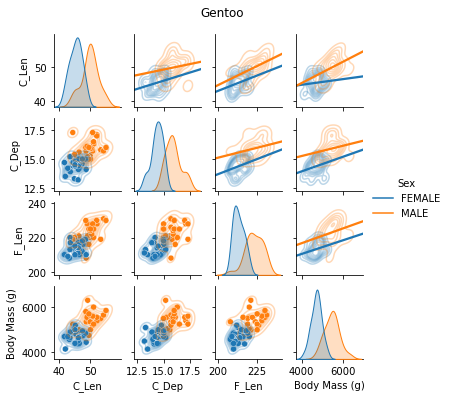

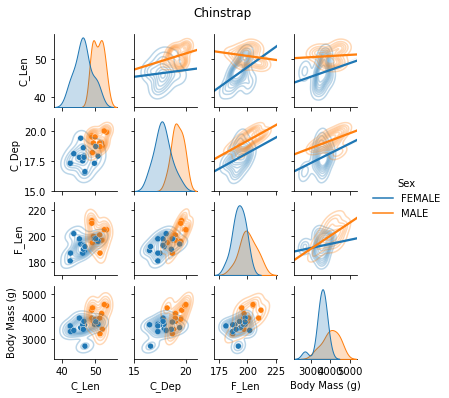

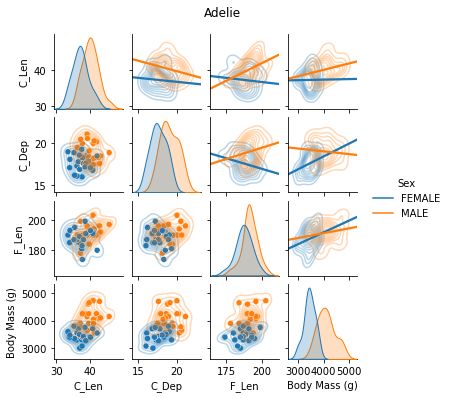

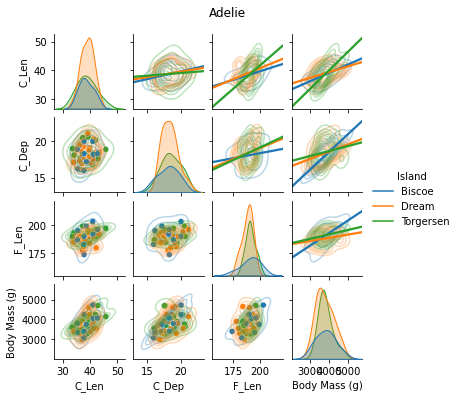

In [36]:
pair_Species("Gentoo",'Sex')
pair_Species("Chinstrap",'Sex')
pair_Species("Adelie",'Sex')
pair_Species("Adelie",'Island')

## Train set 과 Test set Data 분포 비교

In [28]:
cols = ['Species', 'Island', 'Clutch', 'Sex','C_Len', 'C_Dep', 'F_Len', '15_N', '13_C']

df1 = train_data.loc[:,cols]
df1['DataSet'] = 'train'
print("df1 데이터 크기 : %s 행 %s 열" % df1.shape)

df2 = test_data.loc[:,cols]
df2['DataSet'] = 'test'
print("df2 데이터 크기 : %s 행 %s 열" % df2.shape)

total_df = pd.concat([df1,df2],ignore_index=True)
print("total_df 데이터 크기 : %s 행 %s 열" % total_df.shape)

df1 데이터 크기 : 114 행 10 열
df2 데이터 크기 : 228 행 10 열
total_df 데이터 크기 : 342 행 10 열


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


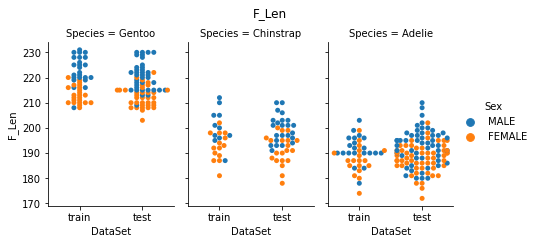

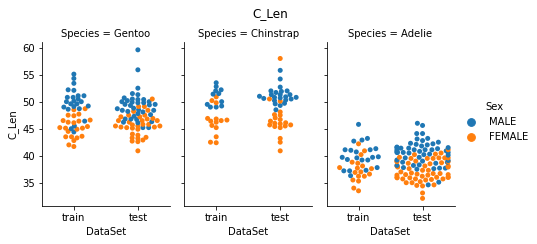

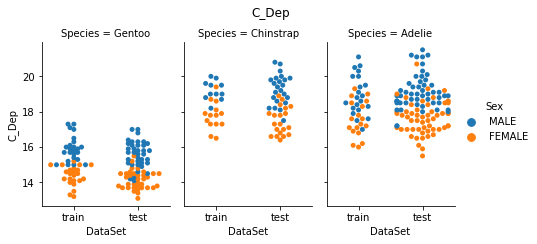

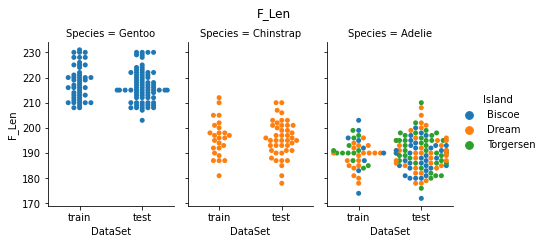

In [37]:
def cat(dataset,y_Data,hue_Data="Sex"):        
    g = sns.catplot(data=dataset,x="DataSet", y=y_Data, col="Species",
                hue=hue_Data, height=3, aspect=0.7, kind="swarm")
    g.fig.suptitle(y_Data,y=1.05)
    display(g)

cat(total_df,"F_Len")
cat(total_df,"C_Len")
cat(total_df,"C_Dep")
cat(total_df,"F_Len", hue_Data = "Island")

## Validate ML

1. Species, Sex별로 cluster 를 나누고 싶음. 

2. [C_Len,C_Dep,F_Len] 을 x,y,z 축으로 잡고 집단을 나누어 그래프를 그리면, 각각의 cluster는 기울어진 원통 모양으로 분포해있을 것 같음. (cluster마다 원통이 기울어진 각도와 직경이 다름)

3. 차원축소를 통해 해당 원통의 [기울어진 각도, 길이, 직경] 정도 성분으로 예측모델을 구축하고 싶음.

4. 해당 원통의 중심축 방향은 Body Mass와 관련성이 깊을 것으로 예상됨. 

5. 해당 원통의 중심각 성분은 완전히 무시하고, 직경 성분만 가져가도 분류에 필요한 분산이 최대한 보존될 것으로 예쌍됨.

## Write to CSV